In [18]:
import numpy as np
import matplotlib.pyplot as plt

class LogisticModel:
    """
    self.t = time
    self.model_values = 
    
    self.
    self.
    
    """
    def __init__(self, n_biomarkers=10, step=0.05, n_steps=1000):
        self.n_biomarkers = n_biomarkers + 1
        self.step = step
        self.n_steps = n_steps
        self.model_values = None
        self.connectivity_matrix = None

    def multi_logistic_deriv_force(self, K, f, x):
        return np.dot(np.eye(K.shape[0]) - np.diag(x), np.dot(K, x) + f)

    def fit(self):
        step = self.step
        n_steps = self.n_steps
        n_biomarkers = self.n_biomarkers

        # params
        neg_frac = 0.01
        t0 = -neg_frac * n_steps * step 
        t = np.arange(t0, (n_steps + 1) * step, step)
        x0 = np.zeros(n_biomarkers)
        f = np.zeros(n_biomarkers)
        f[0] = 0.01


        x = np.zeros((n_biomarkers, len(t)))
        zero_ind = np.where(t == 0)[0][0]
        x[:, zero_ind] = x0

        K = np.zeros((n_biomarkers, n_biomarkers))
        for i in range(n_biomarkers - 1):
            K[i, i + 1] = 1
            K[i, i - 1] = 1
        self.connectivity_matrix = K
        print(K)
        
        # backward integration
        for i in range(zero_ind - 1, -1, -1):
            force = np.zeros_like(f)
            dx_dt = self.multi_logistic_deriv_force(K, force, x[:, i + 1])
            x[:, i] = np.maximum(0, x[:, i + 1] - dx_dt * step)

        # forward integration
        for i in range(zero_ind, n_steps + zero_ind):
            force = np.exp(t[i] * f) - 1
            dx_dt = self.multi_logistic_deriv_force(K, force, x[:, i])
            x[:, i + 1] = x[:, i] + dx_dt * step
            
        self.model_values = x[0:n_biomarkers-1,:]
        self.t = t
        
        print(self.model_values.shape)
        print(t.shape)
        
        return self

    def plot(self):
        plt.figure(figsize=(12, 4))
        for i in range(self.n_biomarkers-1):
            plt.plot(self.t, self.model_values[i, :], label=f'biomarker {i+1}')
        plt.xlabel('time')
        plt.ylabel('biomarker Value')
        plt.legend()
        plt.grid()
        plt.show()

### generate model and sample

[[0. 1. 0. 1.]
 [1. 0. 1. 0.]
 [0. 1. 0. 1.]
 [0. 0. 0. 0.]]
(3, 102)
(102,)


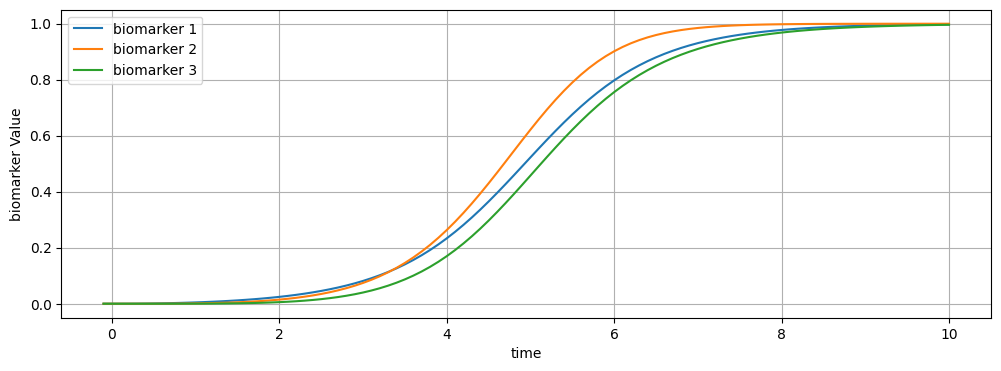

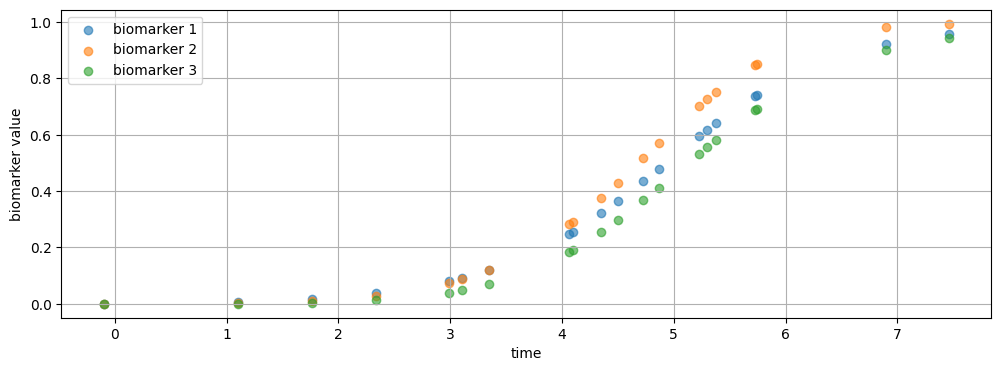

In [21]:
n_biomarkers = 3
n_samples = 20

model = LogisticModel(n_biomarkers=n_biomarkers, step=0.1, n_steps=100)
model.fit()
model.plot()

y = model.model_values[:n_biomarkers, :]
t = model.t

mean_time = 0.5 * (t.max() - t.min())
std_time = 0.2 * (t.max() - t.min())

patient_times = np.random.normal(loc=mean_time, scale=std_time, size=n_samples)
patient_times = np.sort(np.clip(patient_times, t.min(), t.max()))
sampled_values = np.zeros((n_samples, n_biomarkers))

for i in range(n_samples):
    for j in range(n_biomarkers):
        sampled_values[i, j] = np.interp(
            patient_times[i], t, y[j, :]
        )

plt.figure(figsize=(12, 4))
for i in range(n_biomarkers):
    plt.scatter(patient_times, sampled_values[:, i], label=f'biomarker {i+1}', alpha=0.6)
plt.xlabel('time')
plt.ylabel('biomarker value')
plt.legend()
plt.grid()
plt.show()

In [ ]:
from lmfit import Parameters, minimize, report_fit
from scipy.integrate import solve_ivp

# dx/dt = (I - diag(x)) * (Kx + f)
def multi_logistic_ODE(t, x, K, f):
    # x is a vector of length n_biomarkers
    # K is n_biomarkers-by-n_biomarkers
    # f is length n_biomarkers
    n = len(x)
    I = np.eye(n)
    dxdt = (I - np.diag(x)) @ (K @ x + f)
    return dxdt

# second step is to define a residual function for least squares fitting.
# params should contain all elements of K and f, and possibly initial conditions.
def lsq_multi_ODE(params, t_obs, data):
    n_biomarkers = 3

    # "pythonic" way of extracting value for each biomarker
    x0 = np.array([params[f'y0_{i}'].value for i in range(n_biomarkers)])
    f = np.array([params[f'f_{i}'].value for i in range(n_biomarkers)])
    
    # get each k as individual param
    K = np.zeros((n_biomarkers, n_biomarkers))
    for i in range(n_biomarkers):
        for j in range(n_biomarkers):
            K[i, j] = params[f'K_{i}_{j}'].value


    sol = solve_ivp(multi_logistic_ODE, t_span=(t_obs.min(), t_obs.max()), y0=x0, t_eval=t_obs, args=(K, f), method='DOP853')

    # compute residuals
    # data n_biomarkers x n_times
    # sol.y n_biomarkers x n_times (solution)
    # flatten residual (data - model)
    residuals = (data - sol.y).flatten()
    return residuals


def create_initial_params(n_biomarkers):
    """
    Programatically create initial params because of varying param count
    depending on set valeus and we'd like to do multiple biomarkers simultaneously
    """
    
    params = Parameters()
    # y0 for each biomarker
    for i in range(n_biomarkers):
        params.add(f'y0_{i}', value=0.001)  # this is technically known
    
    # force term for each biomarker
    for i in range(n_biomarkers):
        params.add(f'f_{i}', value=0.001) 

    # unpack each edge in connection K_ij for each biomarker 
    for i in range(n_biomarkers):
        for j in range(n_biomarkers):
            params.add(f'K_{i}_{j}', value=0.0) #TODO: try with 0.1, 0.50, 1

    return params

n_biomarkers = model.model_values.shape[0]
t_obs = model.t
data = model.model_values

# t_obs = patient_times
# data = sampled_values.T

params = create_initial_params(n_biomarkers)
result = minimize(lsq_multi_ODE, params, args=(t_obs, data), method='least_squares', max_nfev=10000, ftol=1e-12, gtol=1e-12, xtol=1e-12)
report_fit(result)


[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 10000
    # data points      = 60
    # variables        = 15
    chi-square         = 7.8062e-04
    reduced chi-square = 1.7347e-05
    Akaike info crit   = -644.985806
    Bayesian info crit = -613.570637
##  Warning: uncertainties could not be estimated:
[[Variables]]
    y0_0:  -0.00906527 (init = 0.001)
    y0_1:  -3.9758e-05 (init = 0.001)
    y0_2:   1.7964e-04 (init = 0.001)
    f_0:    0.01534453 (init = 0.001)
    f_1:    0.00219238 (init = 0.001)
    f_2:   -0.00126730 (init = 0.001)
    K_0_0:  0.39824532 (init = 0)
    K_0_1:  0.45180743 (init = 0)
    K_0_2:  0.37864026 (init = 0)
    K_1_0:  0.57398386 (init = 0)
    K_1_1:  0.65304510 (init = 0)
    K_1_2:  0.53562256 (init = 0)
    K_2_0:  0.36671998 (init = 0)
    K_2_1:  0.41047588 (init = 0)
    K_2_2:  0.36347941 (init = 0)


[[0.39824532 0.45180743 0.37864026]
 [0.57398386 0.6530451  0.53562256]
 [0.36671998 0.41047588 0.36347941]]


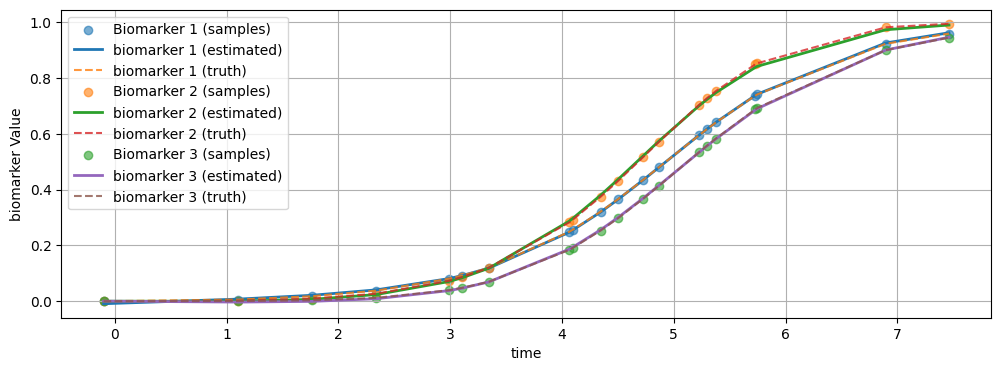

In [24]:
# Extract optimized parameters from the fitting result
def get_optimized_params(result, n_biomarkers):
    y0_estimated = np.array([result.params[f'y0_{i}'].value for i in range(n_biomarkers)])
    f_estimated = np.array([result.params[f'f_{i}'].value for i in range(n_biomarkers)])
    
    K_estimated = np.zeros((n_biomarkers, n_biomarkers))
    for i in range(n_biomarkers):
        for j in range(n_biomarkers):
            K_estimated[i, j] = result.params[f'K_{i}_{j}'].value
    
    return y0_estimated, f_estimated, K_estimated

n_biomarkers = 3
y0_estimated, f_estimated, K_estimated = get_optimized_params(result, n_biomarkers)
print(K_estimated)

# solve with estimated parameters
t_eval = t_obs
sol_estimated = solve_ivp(
    multi_logistic_ODE,
    t_span=(t_eval.min(), t_eval.max()),
    y0=y0_estimated,
    args=(K_estimated, f_estimated),
    t_eval=t_eval,
    method='DOP853'
)

plt.figure(figsize=(12, 4))
for i in range(n_biomarkers):
    plt.scatter(patient_times, sampled_values[:, i], label=f'Biomarker {i+1} (samples)', alpha=0.6)
    plt.plot(t_eval, sol_estimated.y[i, :], label=f'biomarker {i+1} (estimated)', linewidth=2)
    plt.plot(t_obs, data[i, :], '--', label=f'biomarker {i+1} (truth)', alpha=0.8)
plt.xlabel('time')
plt.ylabel('biomarker Value')
plt.legend()
plt.grid()
plt.show()

